# Overview
The purpose of this project is to perform portfolio optimization based on forward-looking indicators. This involves using an ML model to predict returns for stocks and bonds.
---
## Step 1: Data Collection

In [1]:
# Imports
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

# Model Training with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Load the Philadelphia Fed survey of professional forecasters (SPF)data

# GDP Growth
PHILLY_FED_GROWTH_DATA = pd.read_csv('phillyfedgrowthrate.csv')
# Inflation
PHILLY_FED_INFLATION_DATA = pd.read_csv('phillyfedinflationrate.csv')
# Interest
PHILLY_FED_INTEREST_DATA = pd.read_csv('phillyfedinterestrate.csv')
# Risk Premium (Damodaran)
DAMODARAN_RISK_PREMIUM_DATA = pd.read_csv('damodaranriskpremium.csv', skiprows=6)
# Historical Returns (Damodaran)
DAMODARAN_RETURNS_DATA = pd.read_csv('damodaranreturns.csv', skiprows=19)

# Helper functions
    
def get_expected_gdp_growth(date):
    """
    Get GDP growth predictions from Philadelphia Federal Reserve 
    Survey of Professional Forecasters using DRGDP3 data.
    
    Args:
        date: datetime object for which we want the GDP growth prediction
    
    Returns:
        Expected GDP growth rate as a float (e.g., 0.025 for 2.5%)
    """
    try:
        # Parse datetime to year and quarter
        year = date.year
        quarter = (date.month - 1) // 3 + 1
        
        # Find the row with the target date
        mask = (PHILLY_FED_GROWTH_DATA['YEAR'] == year) & (PHILLY_FED_GROWTH_DATA['QUARTER'] == quarter)
        data_row = PHILLY_FED_GROWTH_DATA[mask]
        
        if not data_row.empty:
            # Get DRGDP3 value from the target quarter
            drgdp3_value = data_row['DRGDP3'].iloc[0]
            
            # Handle missing data
            if pd.isna(drgdp3_value) or drgdp3_value == '#N/A':
                # Try DRGDP2 as backup
                drgdp2_value = data_row['DRGDP2'].iloc[0]
                if not pd.isna(drgdp2_value) and drgdp2_value != '#N/A':
                    return float(drgdp2_value) / 100.0
                
                # Final fallback
                return 0.025  # 2.5% default
            else:
                return float(drgdp3_value) / 100.0  # Convert percentage to decimal
        else:
            # No data found for the exact quarter, return default
            print(f"Warning: GDP growth data for quarter {quarter} {year} not found. Using default value of 2.5%.")
            return 0.025  # 2.5% default
            
    except Exception as e:
        print(f"Warning: GDP growth data for quarter {quarter} {year} not properly loaded. Using default value of 2.5%.")
        return 0.025  # 2.5% safe default


def get_expected_inflation(date):
    """
    Get inflation predictions from Philadelphia Federal Reserve 
    Survey of Professional Forecasters using INFPGDP1YR data 
    (1 year GDP deflator).
    
    Args:
        date: datetime object for which we want the inflation prediction
    
    Returns:
        Expected inflation rate as a float (e.g., 0.025 for 2.5%)
    """
    try:
        # Parse datetime to year and quarter
        year = date.year
        quarter = (date.month - 1) // 3 + 1
        
        # Find the row with the target date
        mask = (PHILLY_FED_INFLATION_DATA['YEAR'] == year) & (PHILLY_FED_INFLATION_DATA['QUARTER'] == quarter)
        data_row = PHILLY_FED_INFLATION_DATA[mask]

        if not data_row.empty:
            # Get INFPGDP1YR value from the target quarter
            infpgdp1yr_value = data_row['INFPGDP1YR'].iloc[0]
            
            # Handle missing data
            if pd.isna(infpgdp1yr_value) or infpgdp1yr_value == '#N/A':
                print(f"Warning: Inflation data for quarter {quarter} {year} not found. Trying next quarters.")
                # Try to find data for the next quarter(s) as fallback
                for next_quarters in range(1, 5):  # Try up to 4 quarters ahead
                    next_quarter = quarter + next_quarters
                    next_year = year
                    
                    # Handle year rollover
                    if next_quarter > 4:
                        next_quarter = next_quarter - 4
                        next_year = year + 1

                    next_mask = (PHILLY_FED_INFLATION_DATA['YEAR'] == next_year) & (PHILLY_FED_INFLATION_DATA['QUARTER'] == next_quarter)
                    next_row = PHILLY_FED_INFLATION_DATA[next_mask]

                    if not next_row.empty:
                        next_value = next_row['INFPGDP1YR'].iloc[0]
                        if not pd.isna(next_value) and next_value != '#N/A':
                            return float(next_value) / 100.0
                
                # Final fallback
                print(f"Warning: Inflation data for quarter {quarter} {year} not found. Using default value of 3%.")
                return 0.03  # 3% default
            else:
                return float(infpgdp1yr_value) / 100.0  # Convert percentage to decimal
        else:
            # No data found for the exact quarter, return default
            print(f"Warning: Inflation data for quarter {quarter} {year} not found. Using default value of 3%.")
            return 0.03  # 3% default
            
    except Exception as e:
        print(f"Error: {e}. Using default value of 3%.")
        return 0.03  # 3% safe default


def get_expected_interest_rate(date):
    """
    Get interest rate predictions from Philadelphia Federal Reserve 
    Survey of Professional Forecasters using TBILL1 data 
    (3-month Treasury bill rate forecast).
    
    Args:
        date: datetime object for which we want the interest rate prediction
    
    Returns:
        Expected interest rate as a float (e.g., 0.025 for 2.5%)
    """
    try:
        # Parse datetime to year and quarter
        year = date.year
        quarter = (date.month - 1) // 3 + 1
        
        # Find the row with the target date
        mask = (PHILLY_FED_INTEREST_DATA['YEAR'] == year) & (PHILLY_FED_INTEREST_DATA['QUARTER'] == quarter)
        data_row = PHILLY_FED_INTEREST_DATA[mask]

        if not data_row.empty:
            # Get TBILL1 value from the target quarter
            tbill1_value = data_row['TBILL1'].iloc[0]
            
            # Handle missing data
            if pd.isna(tbill1_value) or tbill1_value == '#N/A':
                # Try TBILL2 as backup
                tbill2_value = data_row['TBILL2'].iloc[0]
                if not pd.isna(tbill2_value) and tbill2_value != '#N/A':
                    return float(tbill2_value) / 100.0
                
                # Final fallback
                print(f"Warning: Interest rate data for quarter {quarter} {year} not found. Using default value of 1%.")
                return 0.01  # 1% default
            else:
                return float(tbill1_value) / 100.0  # Convert percentage to decimal
        else:
            # No data found for the exact quarter, return default
            print(f"Warning: Interest rate data for quarter {quarter} {year} not found. Using default value of 1%.")
            return 0.01  # 1% default
            
    except Exception as e:
        print(f"Error: {e}. Using default value of 1%.")
        return 0.01  # 1% safe default

def get_risk_premium(date):
    """
    Get equity risk premium from Damodaran's historical data using 
    Implied ERP (FCFE) - Free Cash Flow to Equity model.
    
    Args:
        date: datetime object for which we want the risk premium
    
    Returns:
        Expected risk premium as a float (e.g., 0.05 for 5%)
    """
    try:
        # Parse datetime to year
        year = date.year
        
        # Find the row with the target year
        # Clean the data first - remove rows with non-numeric years
        clean_data = DAMODARAN_RISK_PREMIUM_DATA[
            pd.to_numeric(DAMODARAN_RISK_PREMIUM_DATA['Year'], errors='coerce').notna()
        ].copy()
        
        # Convert Year column to int
        clean_data['Year'] = clean_data['Year'].astype(int)
        
        # Find exact year match
        year_data = clean_data[clean_data['Year'] == year]
        
        if not year_data.empty:
            # Get Implied ERP (FCFE) value
            erp_fcfe_value = year_data['Implied ERP (FCFE)'].iloc[0]
            
            # Handle missing data or string formatting
            if pd.isna(erp_fcfe_value) or erp_fcfe_value == '' or erp_fcfe_value == '#N/A':
                # Try to use most recent available data
                recent_data = clean_data[clean_data['Year'] < year].sort_values('Year', ascending=False)
                
                if not recent_data.empty:
                    for _, row in recent_data.head(5).iterrows():  # Check last 5 years
                        recent_erp = row['Implied ERP (FCFE)']
                        if not pd.isna(recent_erp) and recent_erp != '' and recent_erp != '#N/A':
                            # Convert percentage string to float
                            if isinstance(recent_erp, str) and '%' in recent_erp:
                                return float(recent_erp.replace('%', '')) / 100.0
                            else:
                                return float(recent_erp) / 100.0
                
                # Final fallback
                print(f"Warning: Risk premium data for year {year} not found. Using default value of 5%.")
                return 0.05  # 5% default
            else:
                # Convert percentage string to float
                if isinstance(erp_fcfe_value, str) and '%' in erp_fcfe_value:
                    return float(erp_fcfe_value.replace('%', '')) / 100.0
                else:
                    return float(erp_fcfe_value) / 100.0
        else:
            # No exact year match, use most recent available data before the target year
            historical_data = clean_data[clean_data['Year'] <= year].sort_values('Year', ascending=False)
            
            if not historical_data.empty:
                recent_erp = historical_data['Implied ERP (FCFE)'].iloc[0]
                if not pd.isna(recent_erp) and recent_erp != '' and recent_erp != '#N/A':
                    # Convert percentage string to float
                    if isinstance(recent_erp, str) and '%' in recent_erp:
                        return float(recent_erp.replace('%', '')) / 100.0
                    else:
                        return float(recent_erp) / 100.0
            
            # Final fallback
            print(f"Warning: Risk premium data for year {year} not found. Using default value of 5%.")
            return 0.05  # 5% default
            
    except Exception as e:
        print(f"Error: {e}. Using default risk premium of 5%.")
        return 0.05  # 5% safe default
    
def get_stock_return(date):
    """
    Get quarterly S&P 500 return (including dividends) from Damodaran historical data 
    for the year containing the given date. Converts annual return to quarterly using:
    quarterly_return = (1 + annual_return)^(1/4) - 1
    
    Args:
        date: datetime object for the date
    
    Returns:
        Quarterly S&P 500 return as a float (e.g., 0.0121 for 1.21% quarterly return)
    """
    try:
        # Get the year from the date
        year = date.year
        
        # Clean the data and ensure Year column is numeric
        clean_data = DAMODARAN_RETURNS_DATA.copy()
        clean_data['Year'] = pd.to_numeric(clean_data['Year'], errors='coerce')
        clean_data = clean_data.dropna(subset=['Year'])
        clean_data['Year'] = clean_data['Year'].astype(int)
        
        # Find the row with the target year
        year_data = clean_data[clean_data['Year'] == year]
        
        if not year_data.empty:
            # Get S&P 500 (includes dividends) return
            sp500_return = year_data['S&P 500 (includes dividends)'].iloc[0]
            
            # Handle missing data or string formatting
            if pd.isna(sp500_return) or sp500_return == '' or sp500_return == '#N/A':
                print(f"Warning: S&P 500 data for year {year} not found. Using default 7% annual.")
                annual_return = 0.07
            else:
                # Convert percentage string to float (remove % if present)
                if isinstance(sp500_return, str) and '%' in sp500_return:
                    annual_return = float(sp500_return.replace('%', '')) / 100.0
                else:
                    annual_return = float(sp500_return)  # Assume decimal values
        else:
            # No data found for the year, use most recent available
            historical_data = clean_data[clean_data['Year'] < year].sort_values('Year', ascending=False)
            
            if not historical_data.empty:
                recent_return = historical_data['S&P 500 (includes dividends)'].iloc[0]
                if not pd.isna(recent_return) and recent_return != '' and recent_return != '#N/A':
                    if isinstance(recent_return, str) and '%' in recent_return:
                        annual_return = float(recent_return.replace('%', '')) / 100.0
                    else:
                        annual_return = float(recent_return)
                else:
                    annual_return = 0.07
            else:
                print(f"Warning: S&P 500 data for year {year} not found. Using default 7% annual.")
                annual_return = 0.07
        
        # Convert annual return to quarterly return: quarterly = (1 + annual)^(1/4) - 1
        quarterly_return = (1 + annual_return) ** (1/4) - 1
        return quarterly_return
            
    except Exception as e:
        print(f"Error fetching S&P 500 data for {date}: {e}. Using default 7% annual.")
        annual_return = 0.07
        quarterly_return = (1 + annual_return) ** (1/4) - 1
        return quarterly_return

def get_bond_return(date):
    """
    Get quarterly Baa Corporate Bond return from Damodaran historical data 
    for the year containing the given date. Converts annual return to quarterly using:
    quarterly_return = (1 + annual_return)^(1/4) - 1
    
    Args:
        date: datetime object for the date
    
    Returns:
        Quarterly Baa Corporate Bond return as a float (e.g., 0.0074 for 0.74% quarterly return)
    """
    try:
        # Get the year from the date
        year = date.year
        
        # Clean the data and ensure Year column is numeric
        clean_data = DAMODARAN_RETURNS_DATA.copy()
        clean_data['Year'] = pd.to_numeric(clean_data['Year'], errors='coerce')
        clean_data = clean_data.dropna(subset=['Year'])
        clean_data['Year'] = clean_data['Year'].astype(int)
        
        # Find the row with the target year
        year_data = clean_data[clean_data['Year'] == year]
        
        if not year_data.empty:
            # Get Baa Corporate Bond return
            bond_return = year_data[' Baa Corporate Bond'].iloc[0]
            
            # Handle missing data or string formatting
            if pd.isna(bond_return) or bond_return == '' or bond_return == '#N/A':
                print(f"Warning: Baa Corporate Bond data for year {year} not found. Using default 3% annual.")
                annual_return = 0.03
            else:
                # Convert percentage string to float (remove % if present)
                if isinstance(bond_return, str) and '%' in bond_return:
                    annual_return = float(bond_return.replace('%', '')) / 100.0
                else:
                    annual_return = float(bond_return)  # Assume decimal values
        else:
            # No data found for the year, use most recent available
            historical_data = clean_data[clean_data['Year'] < year].sort_values('Year', ascending=False)
            
            if not historical_data.empty:
                recent_return = historical_data[' Baa Corporate Bond'].iloc[0]
                if not pd.isna(recent_return) and recent_return != '' and recent_return != '#N/A':
                    if isinstance(recent_return, str) and '%' in recent_return:
                        annual_return = float(recent_return.replace('%', '')) / 100.0
                    else:
                        annual_return = float(recent_return)
                else:
                    annual_return = 0.03
            else:
                print(f"Warning: Baa Corporate Bond data for year {year} not found. Using default 3% annual.")
                annual_return = 0.03
        
        # Convert annual return to quarterly return: quarterly = (1 + annual)^(1/4) - 1
        quarterly_return = (1 + annual_return) ** (1/4) - 1
        return quarterly_return
            
    except Exception as e:
        print(f"Error fetching bond data for {date}: {e}. Using default 3% annual.")
        annual_return = 0.03
        quarterly_return = (1 + annual_return) ** (1/4) - 1
        return quarterly_return

## Step 2: Model definition

In [ ]:
# Model Training with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class PortfolioPredictor(nn.Module):
    """
    Neural Network to predict expected stock and bond returns based on 
    forward-looking economic indicators.
    
    Input features (4):
    - Expected GDP Growth
    - Expected Inflation 
    - Expected Interest Rate
    - Equity Risk Premium
    
    Output (2):
    - Expected Stock Return
    - Expected Bond Return
    """
    def __init__(self, input_size=4, hidden_sizes=[64, 32, 16], output_size=2, dropout_rate=0.3):
        super(PortfolioPredictor, self).__init__()
        
        # Build the network layers
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        # Output layer (no activation - we want raw returns which can be negative)
        layers.append(nn.Linear(prev_size, output_size))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._init_weights()
        
        # Store scalers and training state
        self.scaler_X = None
        self.scaler_y = None
        self.is_trained = False
        self.training_data = None
    
    def _init_weights(self):
        """Initialize network weights using Xavier initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        return self.network(x)
    
    def train_model(self, X=None, y=None, epochs=2000, learning_rate=0.001, batch_size=16):
        """
        Train the model and store scalers internally.
        
        Args:
            X: Feature matrix (optional - will prepare data if not provided)
            y: Target matrix (optional - will prepare data if not provided)
            epochs: Number of training epochs
            learning_rate: Learning rate for optimizer
            batch_size: Batch size for training
        
        Returns:
            training_history: Loss history
        """
        
        print(f"Training Portfolio Prediction Model...")
        
        # Prepare data if not provided
        if X is None or y is None:
            print("   Preparing training data...")
            X, y, dates = prepare_training_data()
            self.training_data = (X, y, dates)
        
        # Scale the features and targets
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y)
        
        # Split into train/validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X_scaled, y_scaled, test_size=0.2, random_state=42
        )
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.FloatTensor(y_val)
        
        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Initialize loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)
        
        # Training history
        train_losses = []
        val_losses = []
        
        # Training loop
        self.train()
        for epoch in range(epochs):
            epoch_train_loss = 0.0
            
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self(batch_X)
                loss = criterion(outputs, batch_y)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                epoch_train_loss += loss.item()
            
            # Calculate average training loss
            avg_train_loss = epoch_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation loss
            self.eval()
            with torch.no_grad():
                val_outputs = self(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()
                val_losses.append(val_loss)
            self.train()
            
            # Update learning rate
            scheduler.step(val_loss)
            
            # Print progress
            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"   Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        self.is_trained = True
        print(f"Training completed!")
        print(f"   Final Train Loss: {train_losses[-1]:.6f}")
        print(f"   Final Val Loss: {val_losses[-1]:.6f}")
        
        # Training history
        training_history = {
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        
        return training_history
    
    def predict(self, gdp_growth, inflation, interest_rate, risk_premium):
        """
        Simple prediction method for the model. Auto-trains if not trained yet.
        
        Args:
            gdp_growth: Expected GDP growth rate (e.g., 0.025 for 2.5%)
            inflation: Expected inflation rate (e.g., 0.03 for 3%)
            interest_rate: Expected interest rate (e.g., 0.02 for 2%)
            risk_premium: Expected equity risk premium (e.g., 0.05 for 5%)
        
        Returns:
            (predicted_stock_return, predicted_bond_return): Tuple of quarterly returns
        """
        # Auto-train if not trained yet
        if not self.is_trained or self.scaler_X is None or self.scaler_y is None:
            print("Model not trained yet. Training now...")
            self.train_model()
        
        # Prepare input features
        features = np.array([[gdp_growth, inflation, interest_rate, risk_premium]])
        
        # Scale features
        features_scaled = self.scaler_X.transform(features)
        features_tensor = torch.FloatTensor(features_scaled)
        
        # Make prediction
        self.eval()
        with torch.no_grad():
            prediction_scaled = self(features_tensor)
            prediction = self.scaler_y.inverse_transform(prediction_scaled.numpy())
        
        predicted_stock_return = prediction[0, 0]
        predicted_bond_return = prediction[0, 1]
        
        return predicted_stock_return, predicted_bond_return
    
    def validate(self, test_size=0.2, create_plots=True, show_samples=True):
        """
        Validate the trained model using out-of-sample data.
        Returns performance metrics in a user-friendly format.
        
        Args:
            test_size: Fraction of data to use for testing (default 20%)
            create_plots: Whether to create validation plots (default True)
            show_samples: Whether to show sample predictions (default True)
        
        Returns:
            dict: Validation results with performance metrics
        """
        
        if not self.is_trained or self.scaler_X is None or self.scaler_y is None:
            print("Model not trained yet. Please train the model first using model.train()")
            return None
            
        if not hasattr(self, 'training_data') or self.training_data is None:
            print("No training data stored in model. Cannot validate.")
            return None

        # Get training data
        X, y, dates = self.training_data
        
        # Create chronological train/test split
        n_test = int(len(dates) * test_size)
        test_indices = list(range(len(dates) - n_test, len(dates)))
        train_indices = list(range(len(dates) - n_test))
        
        X_test_split = X[test_indices]
        y_test_split = y[test_indices]
        dates_test_split = [dates[i] for i in test_indices]
        dates_train_split = [dates[i] for i in train_indices]
        
        print(f"   Training period: {dates_train_split[0].strftime('%Y-Q%m')} to {dates_train_split[-1].strftime('%Y-Q%m')} ({len(train_indices)} quarters)")
        print(f"   Testing period: {dates_test_split[0].strftime('%Y-Q%m')} to {dates_test_split[-1].strftime('%Y-Q%m')} ({len(test_indices)} quarters)")
        
        # Generate predictions
        self.eval()
        with torch.no_grad():
            X_test_scaled = self.scaler_X.transform(X_test_split)
            X_test_tensor = torch.FloatTensor(X_test_scaled)
            y_pred_scaled = self(X_test_tensor)
            y_pred_test = self.scaler_y.inverse_transform(y_pred_scaled.numpy())
        
        # Calculate performance metrics
        from sklearn.metrics import mean_squared_error, r2_score
        
        predicted_stock_returns = y_pred_test[:, 0] * 100
        predicted_bond_returns = y_pred_test[:, 1] * 100
        actual_stock_returns = y_test_split[:, 0] * 100
        actual_bond_returns = y_test_split[:, 1] * 100
        
        stock_r2 = r2_score(actual_stock_returns, predicted_stock_returns)
        stock_rmse = np.sqrt(mean_squared_error(actual_stock_returns, predicted_stock_returns))
        stock_mae = np.mean(np.abs(actual_stock_returns - predicted_stock_returns))
        stock_corr = np.corrcoef(actual_stock_returns, predicted_stock_returns)[0, 1]
        
        bond_r2 = r2_score(actual_bond_returns, predicted_bond_returns)
        bond_rmse = np.sqrt(mean_squared_error(actual_bond_returns, predicted_bond_returns))
        bond_mae = np.mean(np.abs(actual_bond_returns - predicted_bond_returns))
        bond_corr = np.corrcoef(actual_bond_returns, predicted_bond_returns)[0, 1]
        
        # Display results
        print(f"Stock Predictions (Quarterly Returns):")
        print(f"   Accuracy (R²): {stock_r2:.1%}")
        print(f"   Typical Error (RMSE): {stock_rmse:.2f}%")
        print(f"   Average Error (MAE): {stock_mae:.2f}%")
        print(f"   Correlation: {stock_corr:.3f}")
        
        print(f"\nBond Predictions (Quarterly Returns):")
        print(f"   Accuracy (R²): {bond_r2:.1%}")
        print(f"   Typical Error (RMSE): {bond_rmse:.2f}%")
        print(f"   Average Error (MAE): {bond_mae:.2f}%")
        print(f"   Correlation: {bond_corr:.3f}")
        
        # Create plots if requested
        if create_plots:            
            # Extract years for coloring
            years = [date.year for date in dates_test_split]
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Stock returns scatter plot
            scatter1 = ax1.scatter(actual_stock_returns, predicted_stock_returns, 
                                  c=years, cmap='viridis', alpha=0.7, s=60, 
                                  edgecolors='black', linewidth=0.5)
            ax1.plot([-15, 15], [-15, 15], 'r--', alpha=0.8, linewidth=2, 
                     label='Perfect Prediction')
            ax1.set_xlabel('Actual Stock Returns (%)', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Predicted Stock Returns (%)', fontsize=12, fontweight='bold')
            ax1.set_title(f'Stock Returns: Predicted vs Actual\n(Accuracy = {stock_r2:.1%})', 
                          fontsize=14, fontweight='bold')
            ax1.grid(True, alpha=0.3)
            ax1.legend(fontsize=10)
            
            cbar1 = plt.colorbar(scatter1, ax=ax1)
            cbar1.set_label('Year', rotation=270, labelpad=20, fontweight='bold')
            
            # Bond returns scatter plot
            scatter2 = ax2.scatter(actual_bond_returns, predicted_bond_returns,
                                  c=years, cmap='viridis', alpha=0.7, s=60,
                                  edgecolors='black', linewidth=0.5)
            ax2.plot([-8, 8], [-8, 8], 'r--', alpha=0.8, linewidth=2,
                     label='Perfect Prediction')
            ax2.set_xlabel('Actual Bond Returns (%)', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Predicted Bond Returns (%)', fontsize=12, fontweight='bold')
            ax2.set_title(f'Bond Returns: Predicted vs Actual\n(Accuracy = {bond_r2:.1%})', 
                          fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            ax2.legend(fontsize=10)
            
            cbar2 = plt.colorbar(scatter2, ax=ax2)
            cbar2.set_label('Year', rotation=270, labelpad=20, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
        
        # Show sample predictions if requested
        if show_samples:
            print(f"\SAMPLE PREDICTIONS:")
            print("-" * 85)
            print("Date\t\tActual Stock\tPredicted\tActual Bond\tPredicted\tStock Error\tBond Error")
            print("-" * 85)
            for i in range(0, min(len(dates_test_split), 10), 2):
                date = dates_test_split[i]
                stock_err = abs(actual_stock_returns[i] - predicted_stock_returns[i])
                bond_err = abs(actual_bond_returns[i] - predicted_bond_returns[i])
                print(f"{date.strftime('%Y-Q%m')}\t\t{actual_stock_returns[i]:7.2f}%\t\t{predicted_stock_returns[i]:7.2f}%\t\t{actual_bond_returns[i]:6.2f}%\t\t{predicted_bond_returns[i]:6.2f}%\t\t{stock_err:.2f}%\t\t{bond_err:.2f}%")
        
        # Return results dictionary
        return {
            'stock_r2': stock_r2,
            'stock_rmse': stock_rmse,
            'stock_mae': stock_mae,
            'stock_correlation': stock_corr,
            'bond_r2': bond_r2,
            'bond_rmse': bond_rmse,
            'bond_mae': bond_mae,
            'bond_correlation': bond_corr,
            'test_period': f"{dates_test_split[0].strftime('%Y-Q%m')} to {dates_test_split[-1].strftime('%Y-Q%m')}",
            'n_test_samples': len(dates_test_split)
        }

def generate_quarterly_dates(start_year, end_year):
    """
    Generate a list of quarter-end dates from start_year to end_year.
    
    Args:
        start_year: Starting year (e.g., 1982)
        end_year: Ending year (e.g., 2023)
    
    Returns:
        List of datetime objects for each quarter end
    """
    dates = []
    for year in range(start_year, end_year + 1):
        # Quarter ends: March 31, June 30, September 30, December 31
        dates.extend([
            datetime.datetime(year, 3, 31),   # Q1
            datetime.datetime(year, 6, 30),   # Q2
            datetime.datetime(year, 9, 30),   # Q3
            datetime.datetime(year, 12, 31),  # Q4
        ])
    return dates

def prepare_training_data():
    """
    Prepare comprehensive training data using real historical data 
    from 1982 to 2023 with forward-looking indicators and realized returns.
    
    Returns:
        X: Features (GDP, Inflation, Interest Rate, Risk Premium)
        y: Targets (Actual Stock Returns, Actual Bond Returns)
        training_dates: List of dates used
    """
    
    print("Preparing Comprehensive Training Data...")
    print("Using quarterly data from 1982 to 2023 (164 quarters)")

    # Generate comprehensive date range
    training_dates = generate_quarterly_dates(1982, 2023)
    
    
    # Collect forward-looking indicators and realized returns
    features = []
    targets = []
    valid_dates = []

    print("\nProcessing historical data...")

    for i, date in enumerate(training_dates):
        try:
            # Get forward-looking economic indicators
            gdp_growth = get_expected_gdp_growth(date)
            inflation = get_expected_inflation(date)
            interest_rate = get_expected_interest_rate(date)
            risk_premium = get_risk_premium(date)
            
            # Get actual realized returns for the next quarter
            stock_return = get_stock_return(date)
            bond_return = get_bond_return(date)
            
            # Only include if we have valid data
            if not (pd.isna(gdp_growth) or pd.isna(inflation) or 
                   pd.isna(interest_rate) or pd.isna(risk_premium) or 
                   pd.isna(stock_return) or pd.isna(bond_return)):
                
                features.append([gdp_growth, inflation, interest_rate, risk_premium])
                targets.append([stock_return, bond_return])
                valid_dates.append(date)
            
            # Progress update every 20 quarters
            if (i + 1) % 20 == 0:
                progress = (i + 1) / len(training_dates) * 100
                print(f"   Progress: {progress:.1f}% - Processed up to {date.strftime('%Y-Q%m')}")
                
        except Exception as e:
            print(f"   Warning: Skipping {date.strftime('%Y-Q%m')} due to error: {str(e)[:50]}...")
            continue
    
    # Convert to numpy arrays
    X = np.array(features)
    y = np.array(targets)
    
    print(f"\nTraining data prepared successfully!")

    return X, y, valid_dates


# Step 3: Train the model

In [3]:
model = PortfolioPredictor()
history = model.train_model()

🔄 Training Portfolio Prediction Model...
   Preparing training data...
Preparing Comprehensive Training Data...
Using quarterly data from 1982 to 2023 (164 quarters)

Processing historical data...
   Progress: 11.9% - Processed up to 1986-Q12
   Progress: 23.8% - Processed up to 1991-Q12
   Progress: 35.7% - Processed up to 1996-Q12
   Progress: 23.8% - Processed up to 1991-Q12
   Progress: 35.7% - Processed up to 1996-Q12
   Progress: 23.8% - Processed up to 1991-Q12
   Progress: 35.7% - Processed up to 1996-Q12
   Progress: 47.6% - Processed up to 2001-Q12
   Progress: 59.5% - Processed up to 2006-Q12
   Progress: 47.6% - Processed up to 2001-Q12
   Progress: 59.5% - Processed up to 2006-Q12
   Progress: 47.6% - Processed up to 2001-Q12
   Progress: 59.5% - Processed up to 2006-Q12
   Progress: 71.4% - Processed up to 2011-Q12
   Progress: 83.3% - Processed up to 2016-Q12
   Progress: 71.4% - Processed up to 2011-Q12
   Progress: 83.3% - Processed up to 2016-Q12
   Progress: 71.4% - 

# Step 4: Validate model using out-of-sample data

   Training period: 1982-Q03 to 2015-Q09 (135 quarters)
   Testing period: 2015-Q12 to 2023-Q12 (33 quarters)
Stock Predictions (Quarterly Returns):
   Accuracy (R²): 84.0%
   Typical Error (RMSE): 1.54%
   Average Error (MAE): 1.28%
   Correlation: 0.955

Bond Predictions (Quarterly Returns):
   Accuracy (R²): 82.6%
   Typical Error (RMSE): 0.97%
   Average Error (MAE): 0.78%
   Correlation: 0.941


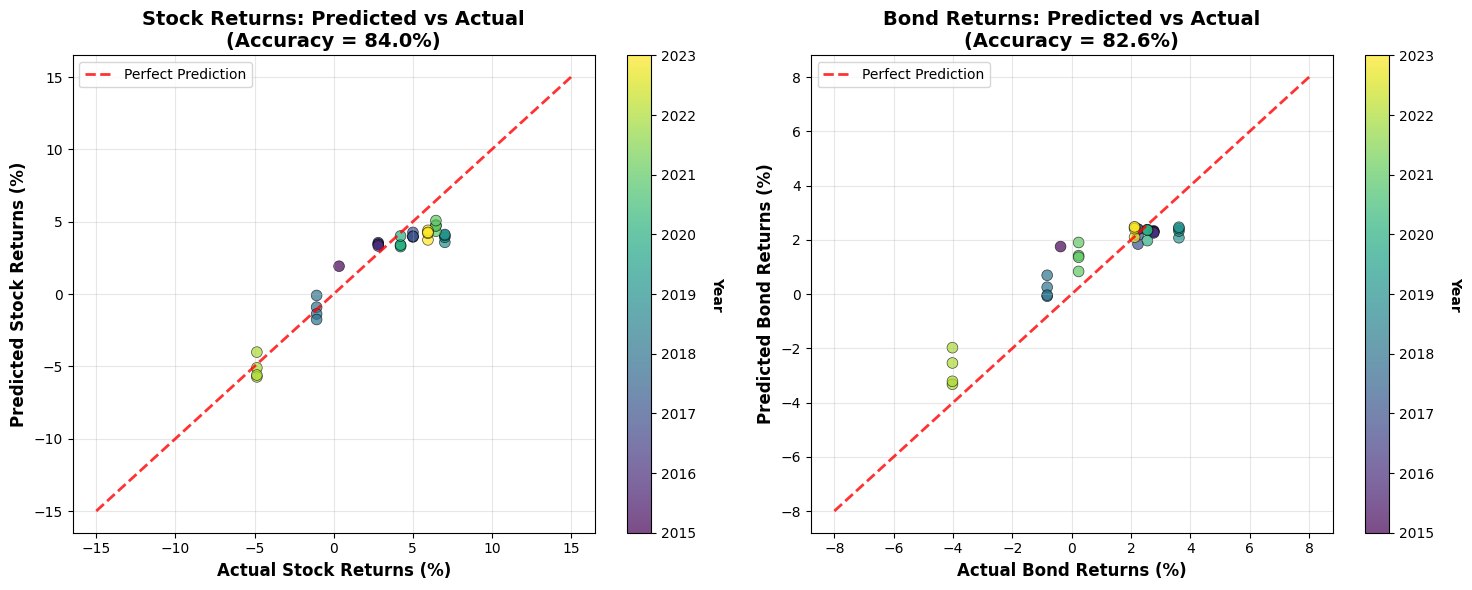

\SAMPLE PREDICTIONS:
-------------------------------------------------------------------------------------
Date		Actual Stock	Predicted	Actual Bond	Predicted	Stock Error	Bond Error
-------------------------------------------------------------------------------------
2015-Q12		   0.34%		   1.92%		 -0.38%		  1.75%		1.58%		2.13%
2016-Q06		   2.82%		   3.45%		  2.76%		  2.30%		0.63%		0.46%
2016-Q12		   2.82%		   3.32%		  2.76%		  2.25%		0.50%		0.51%
2017-Q06		   5.01%		   3.97%		  2.23%		  2.16%		1.04%		0.08%
2017-Q12		   5.01%		   4.00%		  2.23%		  2.40%		1.02%		0.17%
   Stock prediction accuracy: 84.0%
   Bond prediction accuracy: 82.6%
   Average stock error: 1.54% per quarter
   Average bond error: 0.97% per quarter
   Test period: 2015-Q12 to 2023-Q12


In [4]:
validation_results = model.validate()

if validation_results:
    print(f"   Stock prediction accuracy: {validation_results['stock_r2']:.1%}")
    print(f"   Bond prediction accuracy: {validation_results['bond_r2']:.1%}")
    print(f"   Average stock error: {validation_results['stock_rmse']:.2f}% per quarter")
    print(f"   Average bond error: {validation_results['bond_rmse']:.2f}% per quarter")
    print(f"   Test period: {validation_results['test_period']}")

# The model is now ready to use for predictions!

### The model seems to be a very good fit with the out-of-sample data!
---
## Step 5: Use the model to compute returns!

In [5]:
def compute_returns_from_data(gdp_growth, inflation, interest_rate, risk_premium):
    # Use the model to compute the expected return
    stock_return, bond_return = model.predict(gdp_growth, inflation, interest_rate, risk_premium)
    print(f"Stock return: {stock_return*100:.2f}%")
    print(f"Bond return: {bond_return*100:.2f}%")
    print()

def compute_return_from_date(date):
    """
    Compute the expected return based on economic indicators.
    """
    # Get data for that date
    gdp_growth = get_expected_gdp_growth(date)
    inflation = get_expected_inflation(date)
    interest_rate = get_expected_interest_rate(date)
    risk_premium = get_risk_premium(date)

    # Use the model to compute the expected return
    return compute_returns_from_data(gdp_growth, inflation, interest_rate, risk_premium)

# Compute from some sample data points

print("Sample 1: Recession")
compute_returns_from_data(-0.02, 0, 0.03, 0.02)

print("Sample 2: Bubble")
compute_returns_from_data(0.05, 0.03, 0.02, 0.08)

print("Sample 3: Stagflation")
compute_returns_from_data(-0.02, 0.04, 0.03, 0.03)

print("Sample 4: Boomtime")
compute_returns_from_data(0.04, 0.02, 0.01, 0.02)

print("Note that all of these returns are quarterly")

Sample 1: Recession
Stock return: -3.47%
Bond return: 0.65%

Sample 2: Bubble
Stock return: -10.58%
Bond return: -3.32%

Sample 3: Stagflation
Stock return: 1.94%
Bond return: 1.74%

Sample 4: Boomtime
Stock return: 5.26%
Bond return: 1.80%

Note that all of these returns are quarterly


## Step 6: Optimize portfolios based on returns

Sample 1: Recession
Expected returns: Stocks: -3.5%, Bonds: 0.7%, Cash: 0.8%
Sharpe (Stocks only): -0.6030
Sharpe (Bonds only): -0.0479
DO NOT INVEST! Bad market, stay in cash.


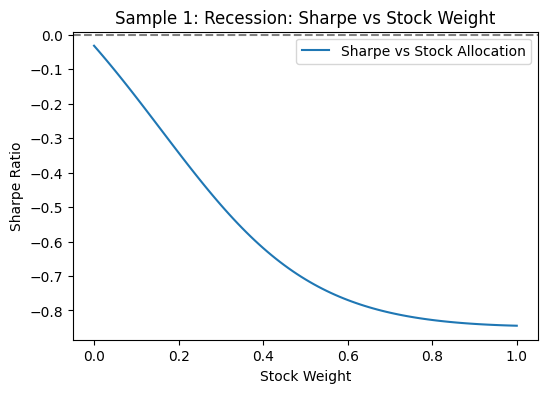

Sample 2: Bubble
Expected returns: Stocks: -10.6%, Bonds: -3.3%, Cash: 0.5%
Sharpe (Stocks only): -1.5836
Sharpe (Bonds only): -1.9100
DO NOT INVEST! Bad market, stay in cash.


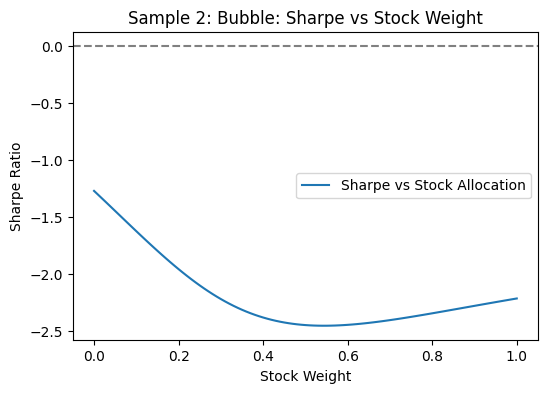

Sample 3: Stagflation
Expected returns: Stocks: 1.9%, Bonds: 1.7%, Cash: 0.8%
Sharpe (Stocks only): 0.1704
Sharpe (Bonds only): 0.4961
Optimized Portfolio Sharpe: 0.3899 | Weights: Stocks=0.2865, Bonds=0.7135
Stock allocation: 28.65%, Bond allocation: 71.35%



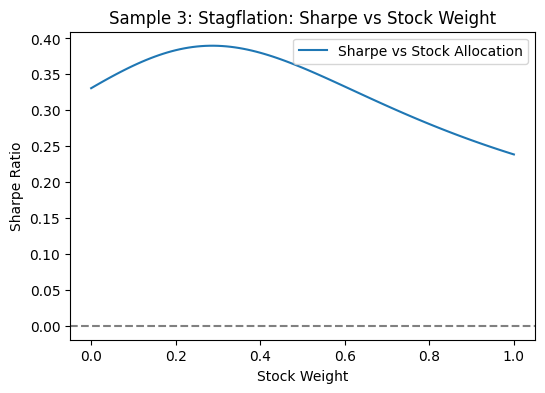

Sample 4: Boomtime
Expected returns: Stocks: 5.3%, Bonds: 1.8%, Cash: 0.2%
Sharpe (Stocks only): 0.7159
Sharpe (Bonds only): 0.7727
Optimized Portfolio Sharpe: 1.0856 | Weights: Stocks=0.5789, Bonds=0.4211
Stock allocation: 57.89%, Bond allocation: 42.11%



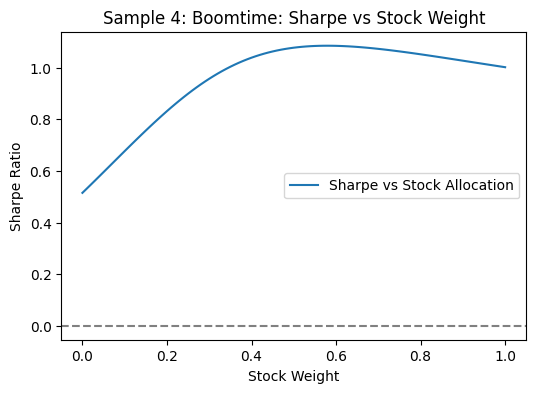

Note: all returns are quarterly


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def sharpe_for_allocation(w_stock, returns, sigma_a=0.07, sigma_b=0.02, rho=-0.3, risk_free_rate=0.0075):
    """Compute Sharpe ratio for a given stock allocation (bond = 1-stock)."""
    w_bond = 1 - w_stock
    r_a, r_b = returns
    a = r_a - risk_free_rate
    b = r_b - risk_free_rate
    
    cov_ab = rho * sigma_a * sigma_b
    Sigma = np.array([[sigma_a**2, cov_ab],
                      [cov_ab, sigma_b**2]])
    
    mu_excess = np.array([a, b])
    w = np.array([w_stock, w_bond])
    
    port_return = w @ mu_excess
    port_vol = np.sqrt(w @ Sigma @ w)
    
    if port_vol == 0:
        return -np.inf
    return port_return / port_vol


def plot_sharpe_curve(returns, title, sigma_a=0.07, sigma_b=0.02, rho=-0.3, risk_free_rate=0.0075):
    """Plot Sharpe ratio as a function of stock allocation."""
    weights = np.linspace(0, 1, 101)
    sharpes = [sharpe_for_allocation(w, returns, sigma_a, sigma_b, rho, risk_free_rate) for w in weights]
    
    plt.figure(figsize=(6,4))
    plt.plot(weights, sharpes, label="Sharpe vs Stock Allocation")
    plt.xlabel("Stock Weight")
    plt.ylabel("Sharpe Ratio")
    plt.title(title)
    plt.axhline(0, color="gray", linestyle="--")
    plt.legend()
    plt.show()


def optimize_portfolio(returns, sigma_a=0.07, sigma_b=0.02, risk_free_rate=0.0075, rho=-0.3):
    """Optimize Sharpe ratio for a 2-asset risky portfolio + cash."""
    returns_a, returns_b = returns
    a = returns_a - risk_free_rate
    b = returns_b - risk_free_rate
    
    cov_ab = rho * sigma_a * sigma_b
    Sigma = np.array([[sigma_a**2, cov_ab],
                      [cov_ab, sigma_b**2]])
    
    mu_excess = np.array([a, b])
    
    # Tangency portfolio weights
    w_tilde = np.linalg.inv(Sigma) @ mu_excess
    w_sum = w_tilde.sum()
    if w_sum == 0:
        w_a, w_b = 0.5, 0.5
    else:
        w_a, w_b = w_tilde / w_sum
    
    # Clip if no shorting
    w_a = max(0, min(1, w_a))
    w_b = max(0, min(1, w_b))
    
    port_return = w_a * a + w_b * b
    port_vol = np.sqrt([w_a, w_b] @ Sigma @ [w_a, w_b])
    sharpe = port_return / port_vol if port_vol > 0 else -np.inf
    
    return w_a, w_b, sharpe


def optimize_from_data_inputs(name, gdp_growth, inflation, interest_rate, risk_premium):
    """Simulate returns, optimize, and plot Sharpe curve."""
    returns = model.predict(gdp_growth, inflation, interest_rate, risk_premium)
    rf_q = interest_rate / 4
    
    print(f"{name}")
    print(f"Expected returns: Stocks: {100*returns[0]:.1f}%, Bonds: {100*returns[1]:.1f}%, Cash: {100*rf_q:.1f}%")
    
    # Individual sharpes
    sharpe_stock = sharpe_for_allocation(1.0, returns, risk_free_rate=rf_q)
    sharpe_bond  = sharpe_for_allocation(0.0, returns, risk_free_rate=rf_q)

    # Optimized portfolio
    stocks, bonds, sharpe_port = optimize_portfolio(
        returns,
        risk_free_rate=rf_q,
        sigma_a=0.05, # Lower for SP500
        sigma_b=0.03, # Higher for Baa bonds
        rho=0.1 # More positive correlation for Baa bonds
    )
    
    print(f"Sharpe (Stocks only): {sharpe_stock:.4f}")
    print(f"Sharpe (Bonds only): {sharpe_bond:.4f}")
    if sharpe_stock < 0 and sharpe_bond < 0:    
        print("DO NOT INVEST! Bad market, stay in cash.")
    else:
        print(f"Optimized Portfolio Sharpe: {sharpe_port:.4f} | Weights: Stocks={stocks:.4f}, Bonds={bonds:.4f}")
        print(f"Stock allocation: {stocks*100:.2f}%, Bond allocation: {bonds*100:.2f}%\n")
    
    plot_sharpe_curve(returns, f"{name}: Sharpe vs Stock Weight",
                      sigma_a=0.05, sigma_b=0.03, rho=0.1, risk_free_rate=rf_q)


# Example usage
optimize_from_data_inputs("Sample 1: Recession", -0.02, 0, 0.03, 0.02)
optimize_from_data_inputs("Sample 2: Bubble", 0.05, 0.03, 0.02, 0.08)
optimize_from_data_inputs("Sample 3: Stagflation", -0.02, 0.04, 0.03, 0.03)
optimize_from_data_inputs("Sample 4: Boomtime", 0.04, 0.02, 0.01, 0.02)

print("Note: all returns are quarterly")
